# Acquire Data and Preprocessing

### Get the .xlsx file

In [1]:

import pandas as pd

df = pd.read_csv('S&P500(2015-2019)_with_hedging_profits.csv')
df['strike_price'] = df['strike_price'] / 1000

# You can modify the "K" here
target_strike = 1000
filtered = df[(df['cp_flag'] == 'P') & (df['strike_price'] == int(target_strike))]
result = filtered[['date', 'cp_flag', 'strike_price', 'ttm', 'option_price']].rename(columns={'ttm': 'maturity'})

result.to_csv('put_result.csv', index=False)

p_df = pd.read_csv('put_result.csv', encoding='utf-8')
p_df.to_excel('put_result.xlsx', index=False, engine='openpyxl')


F:\anaconda3\envs\PINN\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Mapping

In [2]:
put_df = pd.read_excel('put_result.xlsx')
America_df = pd.read_excel('美国标准普尔500指数历史数据.xlsx')

put_df['date'] = pd.to_datetime(put_df['date']).dt.strftime('%Y-%m-%d')
America_df['日期'] = pd.to_datetime(America_df['日期']).dt.strftime('%Y-%m-%d')

merge_df = put_df.merge(
    America_df[['日期', '收盘']],
    left_on='date',
    right_on='日期',
    how='left'
).rename(columns={'收盘': 'underlying asset price'})

merge_df.drop('日期', axis=1, inplace=True)

with pd.ExcelWriter('put_result.xlsx', engine='openpyxl') as writer:
    merge_df.to_excel(writer, index=False)


### Transform .xlsx file into .csv file

In [3]:
csv_df = pd.read_excel('put_result.xlsx', sheet_name='Sheet1', engine='openpyxl')
csv_df.to_csv('put_test.csv', index=False, encoding='utf-8')

# PINN Training - 1D

### Define problem, initial and boundary conditions

In [18]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

n_dim = 1

#Define global variables
r = 0.01
# You can modify the "T" here
T = 1
K = target_strike
sigma = 0.05
DTYPE = 'float32'

# #Fix seeds
# random_seed = 2
# np.random.seed(random_seed)
# tf.random.set_seed(random_seed)


In [19]:

class CSV_DataSample():
    def __init__(self, lb, ub, csv_file:str, x_columns:list,
                 cond=None, N_points=100, DTYPE='float64', split=False, seed=42):
        self.df = pd.read_csv(csv_file)
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        if N_points != 0:
            self.sample_df = self.df.sample(n=N_points, random_state=seed)
        else:
            self.sample_df = self.df
        self.x = tf.cast(
            tf.Variable(self.sample_df[x_columns].values, trainable=False),
            self.DTYPE
        )
        if self.cond != None:
            y_tmp = self.cond(self.x)
            self.y = tf.cast(
                tf.Variable(y_tmp, trainable=False ),
                self.DTYPE
            )
        if split:
            tmp = self.sample_df[x_columns].values
            x_tmp, t_tmp = tmp[:, :-1], tmp[:, -1:]
            self.t = tf.cast(
                tf.Variable(t_tmp, trainable=False ),
                self.DTYPE
            )


In [20]:

#Define domain boundaries
lb = np.array([0., 0.])
ub = np.array([3.*K, T])

#Define conditions
def h_1(inp):
    res = list()
    for inp_val in inp:
        res.append( K - inp_val[0] )
    return np.array(res)

def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = np.zeros( inp.shape[0] )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        x, t = inp_val
        res.append( np.max([0, K-x]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( inp.shape[0] ) * K
    return np.array(res)

#Point sampling
N_to_sample = 300

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = CSV_DataSample(np.array([0., T]), np.array([3.*K, T]),
                              'put_test.csv', ['underlying asset price', 'maturity'],
                              u_0, N_to_sample, DTYPE=DTYPE)
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
dir_sampler = CSV_DataSample(np.array([3.*K, 0.]), np.array([3.*K, T]),
                             'put_test.csv', ['maturity', 'underlying asset price'],
                             g, N_to_sample, DTYPE=DTYPE)
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = CSV_DataSample(np.array([T]), np.array([T]),
                                 'put_test.csv', ['maturity'],
                                 s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = CSV_DataSample(np.array([0.]), np.array([T]),
                                'put_test.csv', ['underlying asset price'],
                                None, N_to_sample, DTYPE=DTYPE)
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = CSV_DataSample(np.array([0.]), np.array([T]),
                                'put_test.csv', ['underlying asset price'],
                                g, N_to_sample, DTYPE=DTYPE)
print( f't: {neu_fb_sampler.x.shape}     y: {neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (300, 2)     y: (300,)
x: (300, 2)     y: (300,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (300, 1)
t: (300, 1)     y: (300,)


In [21]:

test_sampler = CSV_DataSample(lb, ub,
                              'put_test.csv', ['underlying asset price'],
                              cond=None, N_points=0, DTYPE=DTYPE, split=True, seed=2025)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = CSV_DataSample(np.array([0., T]), np.array([3.*K, T]),
                                   'put_test.csv', ['underlying asset price', 'maturity'],
                                   u_0, sample_to_test, DTYPE=DTYPE, seed=2025 )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
dir_sampler_test = CSV_DataSample(np.array([3.*K, 0.]), np.array([3.*K, T]),
                                  'put_test.csv', ['maturity', 'underlying asset price'],
                                  g, sample_to_test, DTYPE=DTYPE, seed=2025 )
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = CSV_DataSample(np.array([T]), np.array([T]),
                                      'put_test.csv', ['maturity'],
                                      s_0, 1, DTYPE=DTYPE, seed=2025 )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = CSV_DataSample(np.array([0.]), np.array([T]),
                                     'put_test.csv', ['underlying asset price'],
                                     None, sample_to_test, DTYPE=DTYPE, seed=2025 )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = CSV_DataSample(np.array([0.]), np.array([T]),
                                     'put_test.csv', ['underlying asset price'],
                                     g, sample_to_test, DTYPE=DTYPE, seed=2025 )
print( f't: {neu_fb_sampler_test.x.shape}     y: {neu_fb_sampler_test.y.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}


PDE COnditions

x: (1000, 2)     y: (1000,)
x: (1000, 2)     y: (1000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (1000, 1)
t: (1000, 1)     y: (1000,)


In [24]:

# #---------------- PDE Conditions
# # initial
# init_S_t = init_sampler.x.numpy()
# init_P = init_sampler.y.numpy()
# init_header = "underlying asset price, time, price"
# init_data = np.hstack([init_S_t, init_P.reshape(-1, 1)])
# np.savetxt(f"1D_init_data.csv", init_data, delimiter=", ", header=init_header)
#
# # dirichlet
# dir_S_t = dir_sampler.x.numpy()
# dir_P = dir_sampler.y.numpy()
# dir_header = "time, underlying asset price, price"
# dir_data = np.hstack([dir_S_t, dir_P.reshape(-1, 1)])
# np.savetxt(f"1D_dir_data.csv", dir_data, delimiter=", ", header=dir_header)
#
# #---------------- Free Boundary Conditions
# # initial_fb
# init_fb_S_t = init_fb_sampler.x.numpy()
# init_fb_P = init_fb_sampler.y.numpy()
# init_fb_header = "time, underlying asset price"
# init_fb_data = np.hstack([init_fb_S_t, init_fb_P.reshape(-1, 1)])
# np.savetxt(f"1D_init_fb_data.csv", init_fb_data, delimiter=", ", header=init_fb_header)
#
# # dirichlet_fb
# dir_fb_header = "underlying asset price"
# dir_fb_data = dir_fb_sampler.x.numpy()
# np.savetxt(f"1D_dir_fb_data.csv", dir_fb_data, delimiter=", ", header=dir_fb_header)
#
# # neumann_fb
# neu_fb_S_t = neu_fb_sampler.x.numpy()
# neu_fb_P = neu_fb_sampler.y.numpy()
# neu_fb_header = "underlying asset price, price"
# neu_fb_data = np.hstack([neu_fb_S_t, neu_fb_P.reshape(-1, 1)])
# np.savetxt(f"1D_neu_fb_data.csv", neu_fb_data, delimiter=", ", header=neu_fb_header)
#
# ############## test ##############
# #---------------- PDE Conditions
# # the whole data
# test_data = test_sampler.x.numpy()  #only underlying asset price, without time
# test_header = "underlying asset price"
# np.savetxt(f"1D_test_data.csv", test_data, delimiter=", ", header=test_header)
#
# # initial_test
# init_test_S_t = init_sampler_test.x.numpy()
# init_test_P = init_sampler_test.y.numpy()
# init_test_header = "underlying asset price, time, price"
# init_test_data = np.hstack([init_test_S_t, init_test_P.reshape(-1, 1)])
# np.savetxt(f"1D_test_init_data.csv", init_test_data, delimiter=", ", header=init_test_header)
#
# # dirichlet_test
# dir_test_S_t = dir_sampler_test.x.numpy()
# dir_test_P = dir_sampler_test.y.numpy()
# dir_test_header = "time, underlying asset price, price"
# dir_test_data = np.hstack([dir_test_S_t, dir_test_P.reshape(-1, 1)])
# np.savetxt(f"1D_test_dir_data.csv", dir_test_data, delimiter=", ", header=dir_test_header)
#
# #---------------- Free Boundary Conditions
# # initial_fb_test
# init_fb_test_S_t = init_fb_sampler_test.x.numpy()
# init_fb_test_P = init_fb_sampler_test.y.numpy()
# init_fb_test_header = "time, underlying asset price"
# init_fb_test_data = np.hstack([init_fb_test_S_t, init_fb_test_P.reshape(-1, 1)])
# np.savetxt(f"1D_test_init_fb_data.csv", init_fb_test_data, delimiter=", ", header=init_fb_test_header)
#
# # dirichlet_fb_test
# dir_fb_test_data = dir_fb_sampler_test.x.numpy()
# dir_fb_test_header = "underlying asset price"
# np.savetxt(f"1D_test_dir_fb_data.csv", dir_fb_test_data, delimiter=", ", header=dir_fb_test_header)
#
# # neumann_fb_test
# neu_fb_test_S_t = neu_fb_sampler_test.x.numpy()
# neu_fb_test_P = neu_fb_sampler_test.y.numpy()
# neu_fb_test_header = "underlying asset price, price"
# neu_fb_test_data = np.hstack([neu_fb_test_S_t, neu_fb_test_P.reshape(-1, 1)])
# np.savetxt(f"1D_test_neu_fb_data.csv", neu_fb_test_data, delimiter=", ", header=neu_fb_test_header)


### PINN

In [22]:

#Define PDE
def pde(tape, xs, ts, u_val, u_x):
    u_xx = tape.gradient(u_x, xs)
    u_t = tape.gradient(u_val, ts)
    del(tape)
    u_val = tf.cast(u_val, DTYPE)
    f = (r * xs * u_x) + u_t + (sigma**2 * xs**2 * u_xx)/2 - (r * u_val)
    return f


In [23]:

import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                                 self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                                 self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values
                            ) * K - s_values
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values
                    ) * K - s_values
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=False)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-test_ibc_fb_cond['Neumann'].y)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                               training=False)
        x_f = tf.reshape(test_sampler.x[ test_sampler.x > s_values ],
                          (-1,1) )
        t_f = tf.reshape(test_sampler.t[ test_sampler.x > s_values ],
                          (-1,1) )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            pinn_tape.watch(x_f)
            pinn_tape.watch(t_f)
            #Apply u function for unsupervised
            u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                            training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims( test_ibc_cond['Initial'].y, axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=False)
            dir_loss = tf.math.reduce_mean(
                tf.math.square(pinn_dc-test_ibc_cond['Dirichlet'].y)
                )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l


### Example

PINNs - Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          


1         0.01096049     109.861991     120.541465     0.00000000     1000057.25     978830.062     0.00000000     1978887.25     979060.500     
51        0.00005888     0.58889210     39164.6992     0.00000000     876671.125     545235.750     0.00000000     1421906.87     584401.062     
101       0.00010282     1.02826166     120418.453     0.00000000     811753.250     306871.187     0.00000000     1118624.50     427290.687     
151       0.00011038     1.10385668     190341.468     0.00000000     761383.125     190350.046     0.00000000     951733.187     380692.625     
201       0.00005692     0.56922340     180380.734     0.00000000     721534.750     180386.625     0.00000000     901921.375     360767.937     
251       0.00002624     0.26249870     172574.625     0.00000000     690306.125     172578.406     0.00000000     862884.

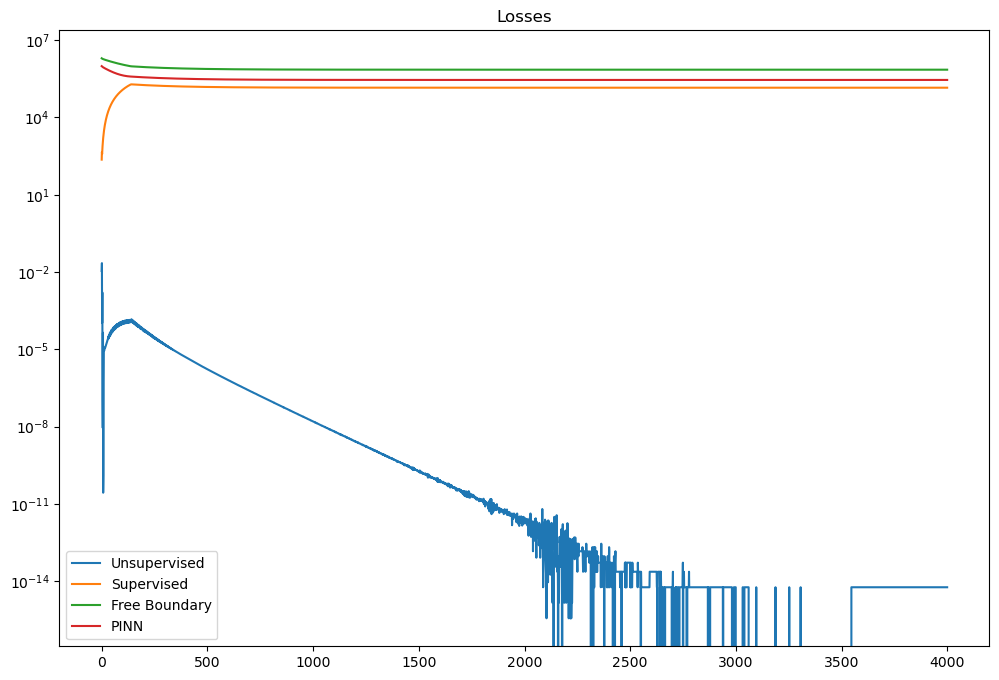

          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.00000000     0.00000000     142747.859     0.00000000     570977.812     142741.015     0.00000000     713718.812     285488.875     


In [24]:

from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 500, 0.9, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':my_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':20,
          'pde_weight':1, 'epochs':4000, 'verbose':50}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=30000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START
